# Alternative Tracing Methods

![AWTT](../../images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](../../images/alternative_ways_to_trace_1.png)

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

USER_AGENT environment variable not set, consider setting it to identify your requests.


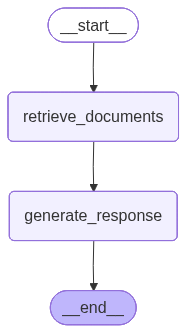

In [2]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [3]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To set up tracing with LangChain, you need to configure your environment by setting a few environment variables. After that, you can log a trace by following the guidelines provided in the Trace With LangChain documentation. For detailed instructions, refer to the specific setup guide available in the LangChain documentation.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 1362, 'total_tokens': 1421, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CLuoZa9NT13

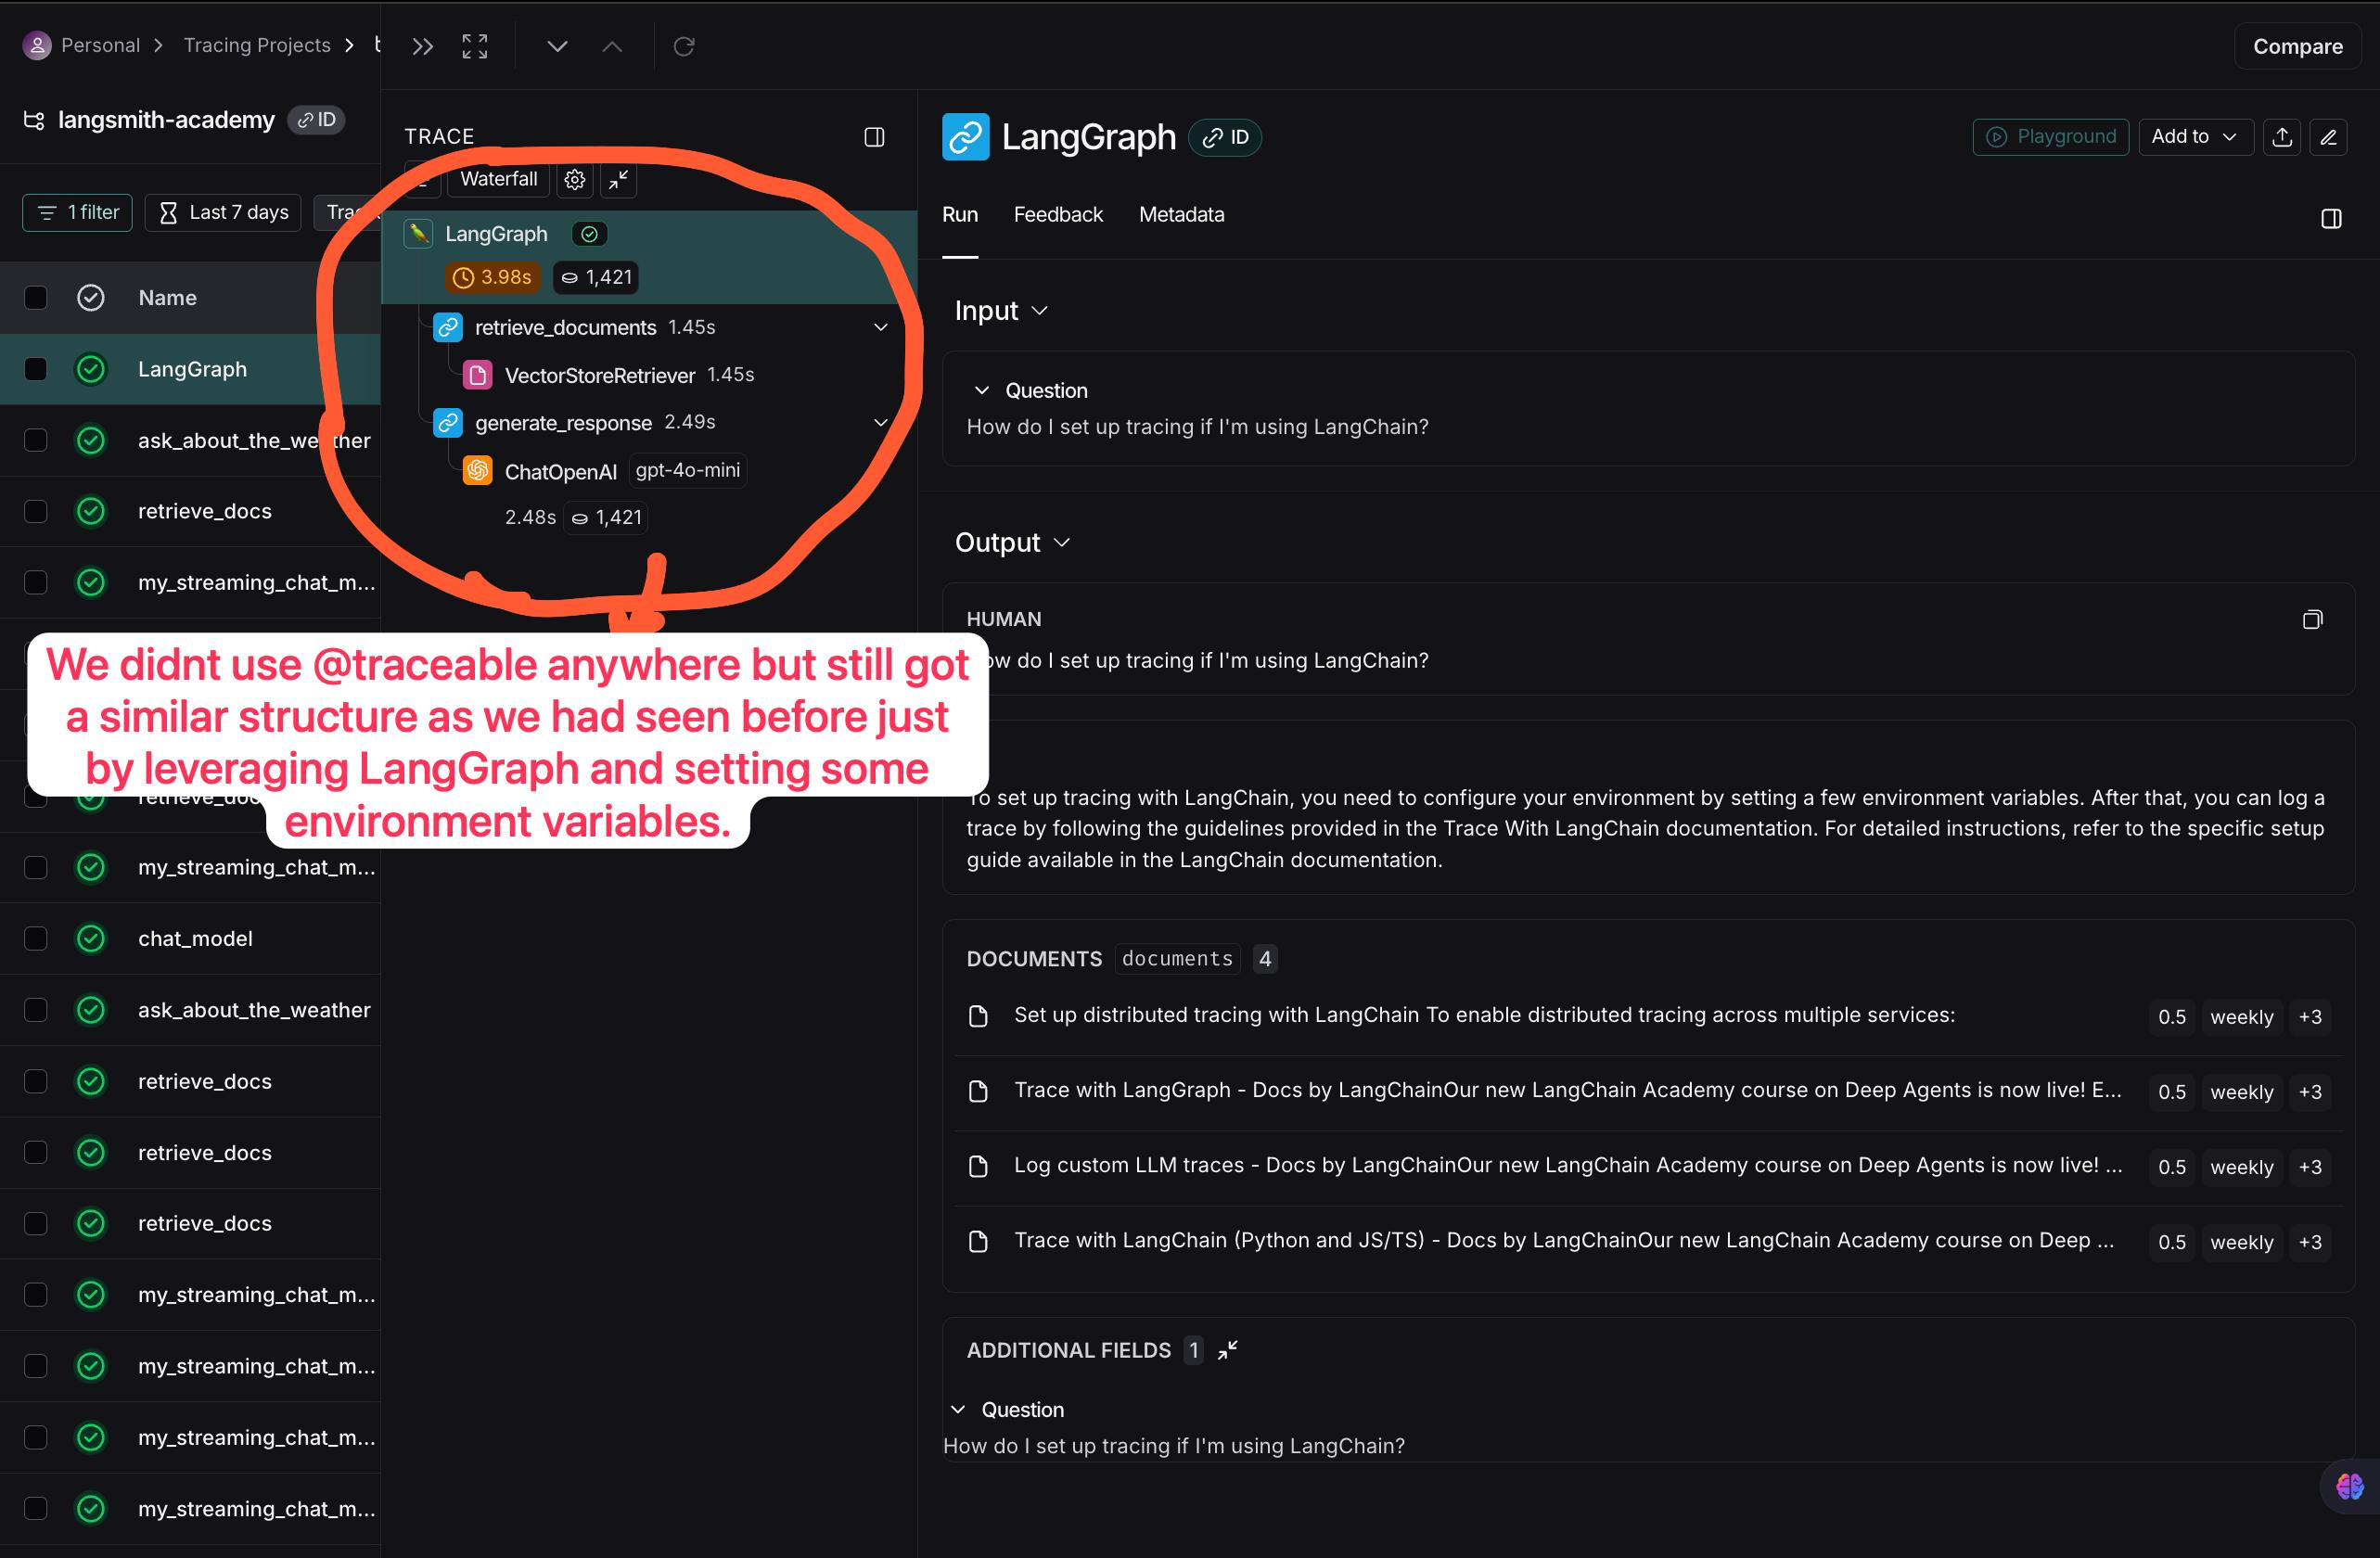

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_2.png)

In [9]:
from langsmith import traceable, trace
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
# TODO: Remove traceable, and use with trace()

def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # TODO: Use with trace()
    with trace(
         name="Generate Response",
          run_type="chain", 
          inputs={"question": question, "formatted_docs": formatted_docs},
          metadata={"foo": "bar"},
      ) as ls_trace:
      messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    response = call_openai(messages)
    # TODO: End your trace and write outputs to LangSmith
    ls_trace.end(outputs={"output": response})
    return response

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [10]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the tracing context in LangChain, you can use the `tracing_context` context manager. Wrap your invocation code within `with ls.tracing_context(enabled=True):` to enable tracing for that specific invocation. If you want to disable tracing for certain invocations, you can set `enabled=False` within the context manager.


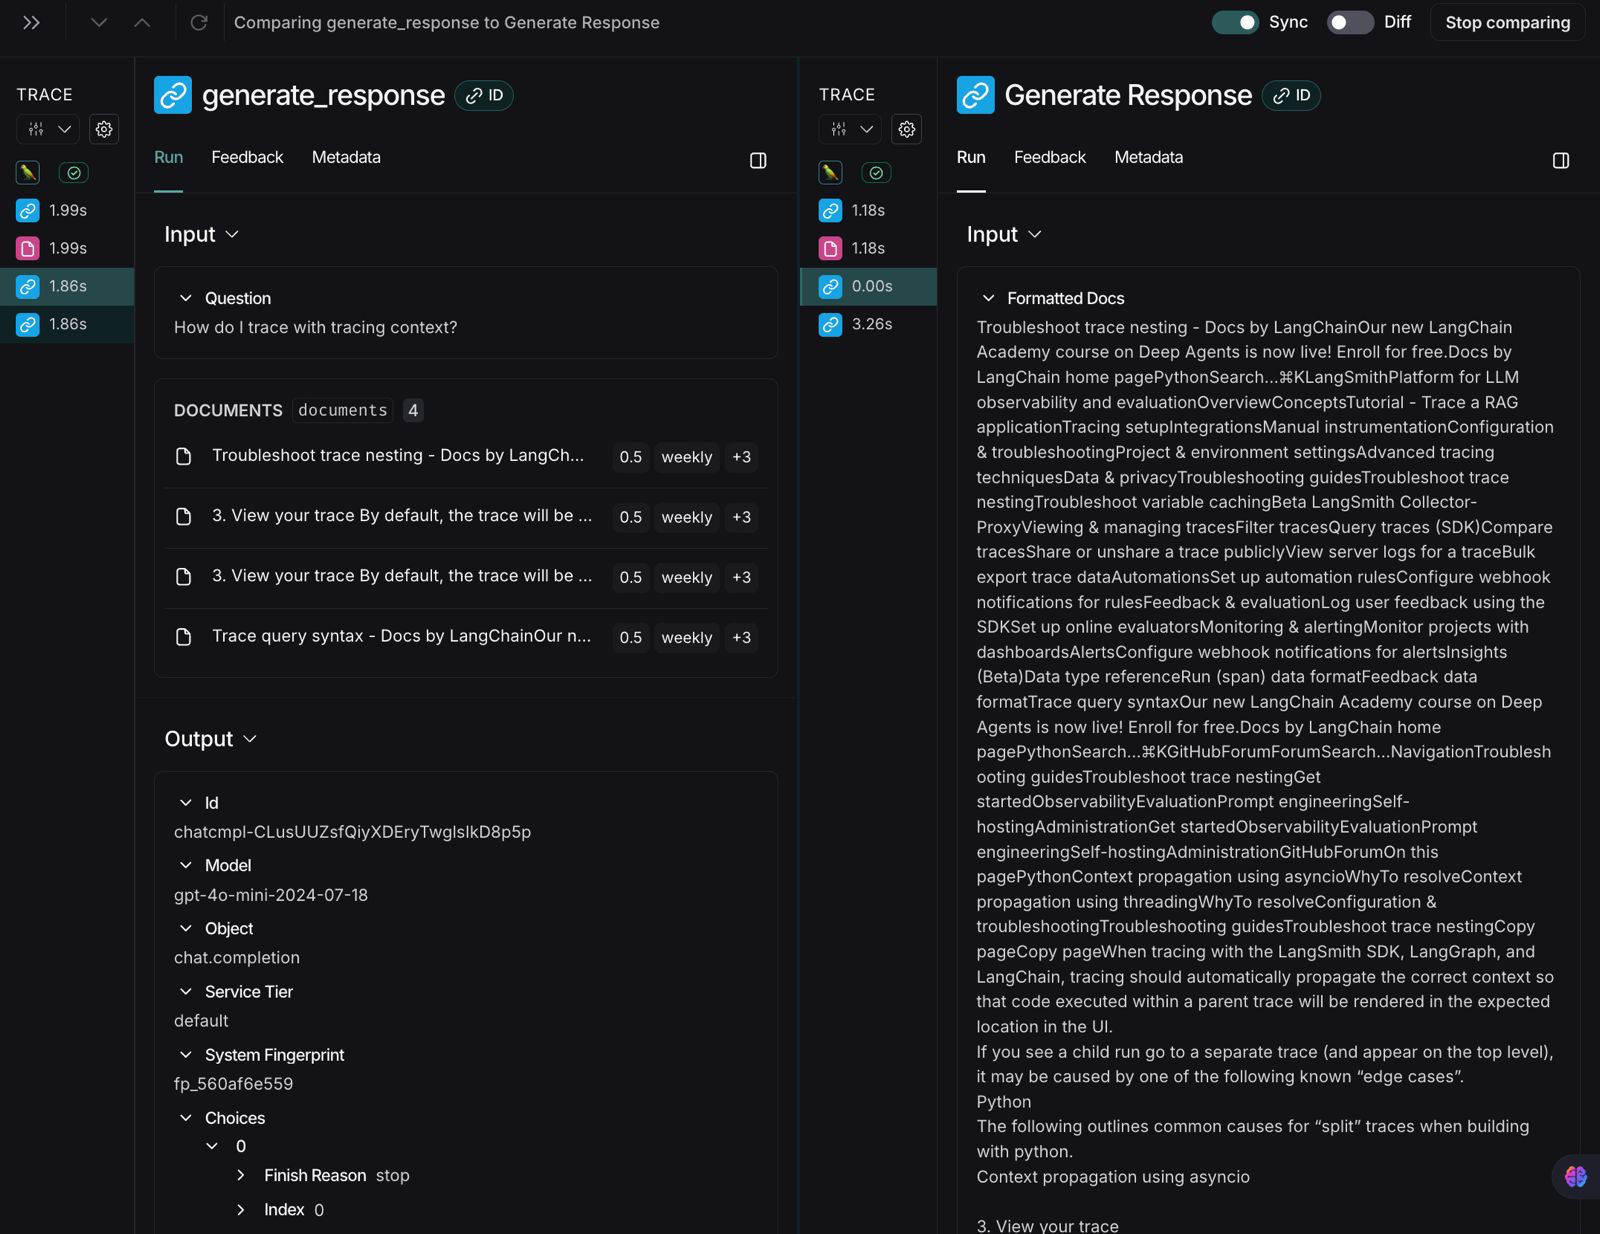


#### Difference between traceable (left) and trace (right)

## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_3.png)

In [ ]:
# TODO: Import wrap_openai
from langsmith.wrappers import wrap_openai
import openai
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

# TODO: Wrap the OpenAI Client
openai_client = wrap_openai(openai.Client())

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    # TODO: We don't need to use @traceable on a nested function call anymore,
    # wrap_openai takes care of this for us
   

    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_openai(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [12]:
question = "How do I trace with wrap_openai?"
ai_answer = langsmith_rag_with_wrap_openai(question)
print(ai_answer)

To trace with `wrap_openai`, you need to import the function from the `langsmith.wrappers` module and use it to wrap your OpenAI client instance. Ensure that the `LANGSMITH_TRACING` environment variable is set to 'true' and provide your `LANGSMITH_API_KEY` for logging traces. Once set up, you can call OpenAI methods as usual, and the tracing will log automatically without needing additional decorators or function wrapping.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [8]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

openai_client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    langsmith_extra={"metadata": {"foo": "bar"}},
)

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [ ]:
from dotenv import load_dotenv
# I have my env variables defined in a .env file
load_dotenv(dotenv_path="../../.env", override=True)

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [ ]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [ ]:
from langsmith import RunTree
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    openai_response = call_openai(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def call_openai(
    parent_run: RunTree, messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="OpenAI Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    openai_response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.choices[0].message.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output
    


In [ ]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)